#  Projeção do IPCA com Machine Learning (XGBoost + Features Macroeconômicas)

##  Autor
**Rafael Eiki Teruya** - Aluno de Economia da FEA-USP 

##  Objetivo
Construir um modelo preditivo para o **IPCA mensal** utilizando técnicas de **Machine Learning** (XGBoost), com base em variáveis macroeconômicas, financeiras e de commodities.

##  Fontes de Dados
- **Banco Central do Brasil (SGS)** → séries de inflação, PIB, juros, câmbio, índices de preços.  
- **FRED (Federal Reserve Bank of St. Louis)** → séries internacionais de commodities (petróleo, soja, milho, café etc.).


##  Metodologia
1. **Coleta e tratamento de dados** de diferentes fontes.  
2. **Engenharia de features**: lags, variações percentuais, volatilidades, interações econômicas.  
3. **Pré-processamento**: normalização com `StandardScaler` e divisão em treino/teste.  
4. **Otimização de hiperparâmetros** com **Optuna**.  
5. **Treinamento do modelo XGBoost**.  
6. **Avaliação do desempenho** utilizando as seguintes métricas:  
   - **RMSE** (Root Mean Squared Error)  
   - **MAE** (Mean Absolute Error)  
   - **R²** (Coeficiente de determinação)  
7. **Visualização dos resultados**: comparação de previsões vs valores reais.

---


# Carregando Bibliotecas

In [1]:
# importando as bibliotecas
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from bcb import sgs
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
from bcb import sgs
import pandas as pd
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Coleta de Séries Econômicas do SGS (Banco Central)

Neste trecho vamos baixar algumas séries macroeconômicas brasileiras diretamente do **SGS (Sistema Gerenciador de Séries Temporais)** do Banco Central do Brasil, utilizando o pacote `bcb`.

- As séries escolhidas incluem índices de preços (IPCA, IPA-DI, IGP-M, INCC, INPC), medidas de inflação (IPCA cheio, IPCA núcleo, acumulado em 12 meses, administrados) e atividade econômica (PIB mensal / IBC-Br).  
- O período inicial definido foi **janeiro de 1992**, garantindo um histórico extenso para análise.  
- A função `sgs.get()` retorna um `DataFrame` com:
  - **Índice temporal** (datas mensais)
  - **Colunas nomeadas** conforme o dicionário de códigos selecionados  

Este dataset servirá como base para a previsão do IPCA.


In [2]:
# Baixando os dados mensais
codigos_selecionados = {
    "IPCA": 433,
    "IPCA_EX1": 16121,
    "IPCA_acumulado_12_meses": 13522,
    "IPCA_administrados": 4449,
    "IPA-DI": 225,
    "IGP-M": 189,
    "INCC": 192,
    "INPC": 188,
    "PIB_mensal": 4380
}

# Baixando os dados mensais
dados_sgs_mensal = sgs.get(codigos_selecionados, start='1992-01-01')
dados_sgs_mensal

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal
Date,,,,,,,,,
1992-01-01,25.94,25.76,497.32,28.50,27.11,23.56,29.87,25.92,13.1
1992-02-01,24.32,24.24,515.13,29.94,25.48,27.86,23.63,24.48,16.3
1992-03-01,21.40,21.77,567.21,22.48,19.67,21.39,27.77,21.62,19.6
1992-04-01,19.93,20.23,662.16,19.35,17.80,19.94,17.42,20.84,23.6
1992-05-01,24.86,24.96,785.81,19.88,21.23,20.43,28.22,24.50,30.1
...,...,...,...,...,...,...,...,...,...
2025-04-01,0.43,0.47,5.53,0.35,0.20,0.24,0.52,0.48,1080004.8
2025-05-01,0.26,0.42,5.32,0.70,-1.38,-0.49,0.58,0.35,1055110.7
2025-06-01,0.24,0.42,5.35,0.60,-2.72,-1.67,0.69,0.23,1041629.6


# Coleta de Séries Diárias (SELIC, Câmbio e CDI)

Além das séries mensais, também vamos buscar séries financeiras que estão disponíveis em **frequência diária** no SGS:  
- **SELIC (código 11)**  
- **Câmbio (código 1, R$/US$)**  
- **CDI (código 12)**  

Com isso, temos um **painel unificado** de indicadores macroeconômicos e financeiros em base **mensal**, pronto para análise e modelagem.


In [3]:
# dicionário com as séries diárias
series_diarias = {
    "SELIC":11,
    "Cambio":1,
    "CDI":12
}

# Baixando os dados diários em blocos de 10 anos para evitar limites da API
anos = [1992,2002,2012,2022]
dados_sgs_diários = pd.DataFrame()
for ano in anos:
    dados_diarios = sgs.get(series_diarias, start=f'{ano}-01-01', end=f'{ano+9}-12-31')
    dados_sgs_diários = pd.concat([dados_sgs_diários, dados_diarios], axis=0)

# Convertendo a frequência de diária para mensal
dados_sgs_diários = dados_sgs_diários.resample('M').first()
dados_sgs_mensal = dados_sgs_mensal.resample('M').first()

In [4]:
# unindo os dois dataframes
df_sgs = dados_sgs_mensal.merge(dados_sgs_diários, left_index=True, right_index=True, how="outer")
df_sgs

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal,SELIC,Cambio,CDI
Date,,,,,,,,,,,,
1992-01-31,25.94,25.76,497.32,28.50,27.11,23.56,29.87,25.92,13.1,1.171667,1079.4000,1.162000
1992-02-29,24.32,24.24,515.13,29.94,25.48,27.86,23.63,24.48,16.3,1.262000,1333.2500,1.266333
1992-03-31,21.40,21.77,567.21,22.48,19.67,21.39,27.77,21.62,19.6,1.252333,1647.5500,1.249333
1992-04-30,19.93,20.23,662.16,19.35,17.80,19.94,17.42,20.84,23.6,1.176000,2007.1000,1.173333
1992-05-31,24.86,24.96,785.81,19.88,21.23,20.43,28.22,24.50,30.1,1.065667,2417.0000,1.065333
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,0.26,0.42,5.32,0.70,-1.38,-0.49,0.58,0.35,1055110.7,0.052531,5.6394,0.052531
2025-06-30,0.24,0.42,5.35,0.60,-2.72,-1.67,0.69,0.23,1041629.6,0.054266,5.6937,0.054266
2025-07-31,0.26,0.50,5.23,0.67,-0.34,-0.77,0.91,0.21,1078347.6,0.055131,5.4511,0.055131


# Hiato do Produto (HP Filter)

Nesta etapa calculamos o **hiato do produto** usando o PIB mensal (IBC-Br) como proxy da atividade econômica.  

- Aplicamos logaritmo na série para suavizar e interpretar em termos percentuais.  
- Separamos tendência e ciclo com o filtro de Hodrick-Prescott (`hpfilter`, λ = 129600 para dados mensais).  
- Definimos o hiato como o desvio percentual do PIB em relação à sua tendência:  
  $
  \text{Hiato} = \frac{PIB - PIB_{tend}}{PIB_{tend}} \times 100
  $

Valores positivos indicam economia **acima do potencial**, negativos indicam **ociosidade**.


In [340]:
# Calculando o hiato do PIB
pib = np.log(df_sgs["PIB_mensal"].dropna())
pib_ciclo, pib_tend = hpfilter(pib, lamb=129600)
df_sgs["PIB_hiato"] = (pib - pib_tend)/pib_tend*100
df_sgs

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal,SELIC,Cambio,CDI,PIB_hiato
Date,,,,,,,,,,,,,
1992-01-31,25.94,25.76,497.32,28.50,27.11,23.56,29.87,25.92,13.1,1.171667,1079.4000,1.162000,-35.905555
1992-02-29,24.32,24.24,515.13,29.94,25.48,27.86,23.63,24.48,16.3,1.262000,1333.2500,1.266333,-33.294695
1992-03-31,21.40,21.77,567.21,22.48,19.67,21.39,27.77,21.62,19.6,1.252333,1647.5500,1.249333,-31.673209
1992-04-30,19.93,20.23,662.16,19.35,17.80,19.94,17.42,20.84,23.6,1.176000,2007.1000,1.173333,-30.143526
1992-05-31,24.86,24.96,785.81,19.88,21.23,20.43,28.22,24.50,30.1,1.065667,2417.0000,1.065333,-27.498117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,0.26,0.42,5.32,0.70,-1.38,-0.49,0.58,0.35,1055110.7,0.052531,5.6394,0.052531,-0.057783
2025-06-30,0.24,0.42,5.35,0.60,-2.72,-1.67,0.69,0.23,1041629.6,0.054266,5.6937,0.054266,-0.205574
2025-07-31,0.26,0.50,5.23,0.67,-0.34,-0.77,0.91,0.21,1078347.6,0.055131,5.4511,0.055131,-0.011269


# Base de Commodities (FRED - St. Louis Fed)

Nesta etapa, carregamos cotações internacionais de commodities baixadas do **FRED (Federal Reserve Economic Data, St. Louis Fed)**.  
As séries utilizadas incluem:  
- Petróleo Brent (POILBREUSDM)  
- Soja (PSOYBUSDM)  
- Milho (PMAIZMTUSDM)  
- Carne (PBEEFUSDM)


In [343]:
# Extrair os dados coletados pelo FRED
df_petroleo = pd.read_csv("Downloads/POILBREUSDM(1).csv")
df_soja = pd.read_csv("Downloads/PSOYBUSDM(1).csv")
df_milho = pd.read_csv("Downloads/PMAIZMTUSDM(1).csv")
df_carne = pd.read_csv("Downloads/PBEEFUSDM(2).csv")


# Concatenar todos os DataFrames em um único DataFrame
df_commodities = pd.concat([df_milho, df_soja, df_petroleo, df_carne], axis=0, ignore_index=True)
df_commodities['observation_date'] = pd.to_datetime(df_commodities['observation_date'])
df_commodities.set_index(df_commodities['observation_date'], inplace=True)
df_commodities.drop('observation_date', axis=1, inplace=True)

# Convertendo a frequência diária para mensal
df_commodities=df_commodities.resample("M").mean().dropna(axis=0)
df_commodities=df_commodities.resample("M").last()
df_commodities

,PMAIZMTUSDM,PSOYBUSDM,POILBREUSDM,PBEEFUSDM
observation_date,,,,
1992-01-31,109.586357,208.610226,18.156522,116.638893
1992-02-29,113.921257,211.159575,18.110000,114.485291
1992-03-31,116.684593,216.143437,17.659091,111.112518
1992-04-30,109.055138,211.297378,19.015909,108.171051
1992-05-31,109.177910,220.369384,19.980952,107.763893
...,...,...,...,...
2025-02-28,221.254544,382.083957,75.193000,285.875000
2025-03-31,207.751691,369.344173,71.741429,292.166667
2025-04-30,215.569093,378.066199,66.927273,294.068182


In [362]:
# unindo os dois dataframes
df = pd.concat([df_sgs, df_commodities], axis=1).dropna(axis=0)
df

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal,SELIC,Cambio,CDI,PIB_hiato,PMAIZMTUSDM,PSOYBUSDM,POILBREUSDM,PBEEFUSDM
1992-01-31,25.94,25.76,497.32,28.50,27.11,23.56,29.87,25.92,13.1,1.171667,1079.4000,1.162000,-35.905555,109.586357,208.610226,18.156522,116.638893
1992-02-29,24.32,24.24,515.13,29.94,25.48,27.86,23.63,24.48,16.3,1.262000,1333.2500,1.266333,-33.294695,113.921257,211.159575,18.110000,114.485291
1992-03-31,21.40,21.77,567.21,22.48,19.67,21.39,27.77,21.62,19.6,1.252333,1647.5500,1.249333,-31.673209,116.684593,216.143437,17.659091,111.112518
1992-04-30,19.93,20.23,662.16,19.35,17.80,19.94,17.42,20.84,23.6,1.176000,2007.1000,1.173333,-30.143526,109.055138,211.297378,19.015909,108.171051
1992-05-31,24.86,24.96,785.81,19.88,21.23,20.43,28.22,24.50,30.1,1.065667,2417.0000,1.065333,-27.498117,109.177910,220.369384,19.980952,107.763893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,1.31,1.33,5.06,3.16,1.03,1.06,0.40,1.48,992799.2,0.049037,5.8687,0.049037,-0.331225,221.254544,382.083957,75.193000,285.875000
2025-03-31,0.56,0.50,5.48,0.18,-0.88,-0.34,0.39,0.51,1065766.2,0.049037,5.7914,0.049037,0.125262,207.751691,369.344173,71.741429,292.166667
2025-04-30,0.43,0.47,5.53,0.35,0.20,0.24,0.52,0.48,1080004.8,0.052531,5.7051,0.052531,0.165598,215.569093,378.066199,66.927273,294.068182
2025-05-31,0.26,0.42,5.32,0.70,-1.38,-0.49,0.58,0.35,1055110.7,0.052531,5.6394,0.052531,-0.057783,204.808448,387.649984,64.092727,292.727273


# Removendo Look-Ahead Bias com Lags

Neste trecho, aplicamos um **lag de 1 mês** em todas as variáveis explicativas, exceto `IPCA`.  

### Conceito-chave:
- **Look-ahead bias** ocorre quando o modelo tem acesso a informações que só seriam conhecidas **no futuro**, gerando previsões irrealisticamente boas.  
- Ao aplicar o lag, **removemos esse viés**, garantindo que cada feature represente apenas dados que estariam realmente disponíveis no período de previsão.

In [363]:
# Aplicando o shift de 1 mês em todas as colunas exceto IPCA
colunas_shift = df.columns[df.columns != "IPCA"]
df[colunas_shift] = df[colunas_shift].shift(1)
df.dropna(axis=0, inplace=True)

# Função para Criar Múltiplos Lags

A função `criar_lags` gera **variáveis defasadas** de um DataFrame, permitindo criar lags múltiplos de todas as colunas de forma automatizada.  

### Parâmetros:
- `dados`: DataFrame com as variáveis originais.  
- `nlags`: lista com os números de períodos para os quais se deseja criar lags (ex.: `[1,2,3]`).

In [364]:
def criar_lags(dados, nlags=None):
    df_lags = pd.DataFrame()
    for lag in nlags:
        for i in range(dados.shape[1]):
            df_lags[f"{dados.columns[i]}_lag{lag}"] = dados[dados.columns[i]].shift(lag)
    return df_lags

# Criação de Features Derivadas

### Features Criadas

1. **`IPCA_tendencia_6m`**: Média móvel dos últimos 6 meses do IPCA, com um lag de 1 mês. Essa feature captura a tendência recente da inflação.

2. **`Selic_Real_Ex-Ante`**: Diferença entre a taxa SELIC e o IPCA acumulado em 12 meses. Representa a taxa de juros real esperada, ajustada pela inflação.

3. **`IPCA_vol6m`**: Volatilidade (desvio padrão) do IPCA nos últimos 6 meses, com um lag de 1 mês. Mede a instabilidade da inflação no curto prazo.

4. **`Nucleo_tendencia_6m`**: Média móvel dos últimos 6 meses do núcleo do IPCA (`IPCA_EX1`), com um lag de 1 mês. Indica a tendência do núcleo da inflação.

5. **`PIB_crescimento_3m`**: Taxa de crescimento do PIB nos últimos 3 meses. Mede a variação percentual da atividade econômica.

6. **`Selic_media6`**: Média móvel da taxa SELIC nos últimos 6 meses. Representa a tendência da política monetária.

7. **`IPA_acumulado_3m`**: Soma do IPA-DI nos últimos 3 meses. Indica a pressão inflacionária no atacado.

8. **`Cambio_vol_3m`**: Volatilidade (desvio padrão) do câmbio nos últimos 3 meses, ajustado para uma escala percentual. Mede a instabilidade cambial.

9. **`Indice_de_commodities`**: Média dos preços das commodities (milho, soja, petróleo, carne, etc.) em cada mês. Representa o impacto das commodities na inflação.


In [365]:
# Criando novas features

# Shift de 1 mês antes de calcular a volatilidade
df['IPCA_tendencia_6m'
] = df['IPCA'].shift(1).rolling(6).mean().astype('float')
df['Selic_Real_Ex-Ante'] = df['SELIC'] - df['IPCA_acumulado_12_meses']
df['IPCA_vol6m'] = df['IPCA'].shift(1).rolling(6).std().astype('float')
df['Nucleo_tendencia_6m'] = df['IPCA_EX1'].shift(1).rolling(6).mean().astype('float')
df['PIB_crescimento_3m'] = (df['PIB_mensal']-df['PIB_mensal'].shift(3))/df['PIB_mensal']
df['Selic_media6'] = df['SELIC'].rolling(6).mean().astype('float')
df['IPA_acumulado_3m'] = df['IPA-DI'].rolling(3).sum().astype('float')
df['Cambio_vol_3m'] = (df['Cambio']/100).rolling(3).std().astype('float')
df['Indice_de_commodities'] = df_commodities.mean(axis=1)



# Criando lags específicos para algumas variáveis
df_lags_ipca = criar_lags(df[["IPCA"]], nlags=[2,4])
df_lags_ipa = criar_lags(df[["IPA-DI"]], nlags=[1,2])
df_lags_pib = criar_lags(df[["PIB_mensal"]], nlags=[1,3])


# unindo todos os dataframes
df = pd.concat([df, df_lags_ipca, df_lags_ipa, df_lags_pib], axis=1).dropna(axis=0)
df = df.replace([-np.inf, np.inf], 0)
df

,IPCA,IPCA_EX1,IPCA_acumulado_12_meses,IPCA_administrados,IPA-DI,IGP-M,INCC,INPC,PIB_mensal,SELIC,...,Selic_media6,IPA_acumulado_3m,Cambio_vol_3m,Indice_de_commodities,IPCA_lag2,IPCA_lag4,IPA-DI_lag1,IPA-DI_lag2,PIB_mensal_lag1,PIB_mensal_lag3
1992-08-31,22.14,21.95,937.94,24.11,22.19,21.84,23.53,22.08,46.1,1.012667,...,1.133889,64.32,5.310771,107.780572,20.21,19.93,20.90,21.23,37.5,23.6
1992-09-30,24.63,21.65,996.37,26.60,27.40,24.63,17.28,22.38,56.7,1.092667,...,1.105667,70.49,6.866984,108.022262,21.83,24.86,22.19,20.90,46.1,30.1
1992-10-31,25.24,24.19,1081.70,21.26,27.17,25.27,34.30,23.98,70.8,1.170667,...,1.092056,76.76,8.557832,106.483842,22.14,20.21,27.40,22.19,56.7,37.5
1992-11-30,22.49,25.17,1130.94,21.46,24.83,26.76,18.91,26.07,89.0,1.202667,...,1.096500,79.40,11.164201,108.704198,24.63,21.83,27.17,27.40,70.8,46.1
1992-12-31,25.24,23.66,1104.20,17.31,24.43,23.43,29.16,22.89,110.4,1.234000,...,1.124556,76.43,14.730900,109.128081,25.24,22.14,24.83,27.17,89.0,56.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,1.31,0.02,4.56,-1.52,0.03,0.27,0.83,0.00,961013.5,0.045513,...,0.041058,2.77,0.002032,241.101625,0.52,0.56,1.08,1.66,1006123.7,1048036.9
2025-03-31,0.56,1.33,5.06,3.16,1.03,1.06,0.40,1.48,992799.2,0.049037,...,0.042686,2.14,0.001706,235.250990,0.16,0.39,0.03,1.08,961013.5,1026206.9
2025-04-30,0.43,0.50,5.48,0.18,-0.88,-0.34,0.39,0.51,1065766.2,0.049037,...,0.044313,0.18,0.002219,238.657687,1.31,0.52,1.03,0.03,992799.2,1006123.7
2025-05-31,0.26,0.47,5.53,0.35,0.20,0.24,0.52,0.48,1080004.8,0.052531,...,0.046374,0.35,0.000818,237.319608,0.56,0.16,-0.88,1.03,1065766.2,961013.5


# Padronização e Divisão Treino/Teste

Neste bloco preparamos os dados para modelagem do IPCA:

- Separamos **X** (features) e **y** (target: IPCA).  
- Aplicamos **StandardScaler** para padronizar médias e desvios das variáveis.  
- Dividimos os dados em **treino (80%)** e **teste (20%)**, mantendo a ordem temporal para preservar consistência na previsão.


In [366]:
# Dividindo em variável dependente e independentes
X = df.drop('IPCA', axis=1).astype('float')
y = df['IPCA'].astype('float')

# Normalizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Dividindo em treino e teste (80% treino, 20% teste)
X_train, y_train = X_scaled[:int(0.8*(len(X)))], y_scaled[:int(0.8*(len(X)))]
X_test, y_test = X_scaled[int(0.8*(len(X))):], y_scaled[int(0.8*(len(X))):]

# Função Objetivo para Otimização com Optuna

Nesta função definimos como o Optuna irá **procurar os melhores hiperparâmetros** para o XGBoost na previsão do IPCA.

### Detalhes:

1. **Espaços de busca dos hiperparâmetros**  
   - `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`, `min_child_weight`, `gamma`, `max_delta_step`  

2. **Modelo**  
   - `XGBRegressor` com os parâmetros sugeridos pelo trial do Optuna.

3. **Validação cruzada**  
   - `KFold(n_splits=10, shuffle=False)` para respeitar a ordem temporal da série.  
   - `cross_val_score` avalia o modelo usando **MSE negativo** como métrica.

4. **Retorno**  
   - A função retorna a média do score negativo do MSE para que o Optuna **minimize o erro**.

> Observação: o uso de `shuffle=False` garante que a validação respeite a sequência temporal, evitando look-ahead bias.


In [398]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "random_state": 42
    }

    # Modelo
    model = XGBRegressor(**params, eval_metric="rmse")

    # Validação cruzada (ajuste se for série temporal!)
    cv = KFold(n_splits=10, shuffle=False)

    # Minimizar MSE
    score = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring="neg_mean_squared_error",
                            n_jobs=-1)
    
    return np.mean(score)


# Função de Busca de Hiperparâmetros com Optuna

A função `search` realiza múltiplas execuções do processo de otimização para identificar os **melhores hiperparâmetros do XGBoost**.  

### Detalhes:

1. **Iterações externas** (`iterações`)  
   - Permite repetir o estudo várias vezes para reduzir variações devido à aleatoriedade da otimização.

2. **Criação do estudo Optuna**  
   - `optuna.create_study(direction="maximize")` cria um estudo para maximizar a função objetivo (negativo do MSE).

3. **Otimização interna**  
   - `study.optimize(objective, n_trials=200, n_jobs=-1)` executa 200 trials paralelos para explorar o espaço de hiperparâmetros definido na função `objective`.

4. **Registro dos resultados**  
   - `melhor_resultado`: lista com os melhores scores de cada iteração.  
   - `melhor_param`: lista com os melhores parâmetros correspondentes.  
   - Ordena os resultados para sempre identificar o **melhor score absoluto**.

5. **Retorno**  
   - Retorna o **menor MSE absoluto** encontrado e os **hiperparâmetros correspondentes**.

> Observação: Repetir múltiplas iterações ajuda a reduzir o risco de escolher um ótimo local ruim devido à aleatoriedade do algoritmo de otimização.


In [411]:
def search(iterações):
    study_lista = []
    param_lista = []
    valor_lista = []
    while len(study_lista) < iterações:
        # Criar estudo e podar estudos ruins cedo
        study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=15))
        # Otimizar
        study.optimize(objective, n_trials=200, n_jobs=-1)
        study_lista.append(study)
        param_lista.append(study.best_params)
        valor_lista.append(study.best_value)
        print(f"Valor da iteração: {valor_lista[-1]}")
    print("Melhor valor encontrado!")
    return np.argmax(valor_lista), param_lista[np.argmax(valor_lista)], study_lista[np.argmax(valor_lista)]

In [416]:
# Executando a busca por hiperparâmetros
melhor_valor, melhores_param, melhor_study = search(10)

Valor da iteração: -1.1673991088699274
Valor da iteração: -1.1878059320236771
Valor da iteração: -1.1757432122845626
Valor da iteração: -1.1716774542035382
Valor da iteração: -1.2036405805665633
Valor da iteração: -1.1779834721167783
Valor da iteração: -1.180450624323029
Valor da iteração: -1.1716471227739071
Valor da iteração: -1.1879329501783142
Valor da iteração: -1.1998973888362383
Melhor valor encontrado!


In [ ]:
# Visualizando os melhores parâmetros
melhores_param

{'n_estimators': 481,
 'max_depth': 2,
 'learning_rate': 0.13260000892385904,
 'subsample': 0.8558075269072032,
 'colsample_bytree': 0.7840336733955681,
 'reg_alpha': 0.058791430520790944,
 'reg_lambda': 1.8819832672764667,
 'min_child_weight': 8,
 'gamma': 0.0014798819192971095,
 'max_delta_step': 2}

## Visualizações da otimização

### Histórico de Otimização

## Gráfico: Histórico de Otimização

O gráfico de **Histórico de Otimização** gerado pelo Optuna mostra a evolução dos valores da função objetivo ao longo dos trials realizados durante o processo de busca pelos melhores hiperparâmetros.

### Interpretação do Gráfico:
1. **Eixo X (Número de Trials)**: Representa o número de tentativas (trials) realizadas pelo Optuna para encontrar a melhor combinação de hiperparâmetros.
2. **Eixo Y (Valor da Função Objetivo)**: Indica o valor da métrica de avaliação (neste caso, o score negativo do MSE) para cada trial. O objetivo é maximizar este valor, o que equivale a minimizar o erro.

### Observações:
- **Convergência**: O gráfico mostra como os valores da função objetivo melhoram ao longo dos trials, indicando que o algoritmo está convergindo para uma solução ótima.
- **Exploração vs Exploração**: Nos primeiros trials, há maior variação nos valores, pois o algoritmo está explorando diferentes combinações de hiperparâmetros. Com o tempo, os valores se estabilizam, indicando que o algoritmo está refinando a busca em torno de uma região promissora.
- **Melhor Valor**: O melhor valor encontrado é destacado no gráfico, representando a combinação de hiperparâmetros que resultou no menor erro.

Este gráfico é útil para avaliar a eficiência do processo de otimização e identificar se mais trials seriam necessários para melhorar os resultados.

In [ ]:
# Visualizando o histórico de otimização
optuna.visualization.plot_optimization_history(melhor_study)

### Importância dos parametros

### Gráfico de Importância dos Parâmetros

O gráfico de **importância dos parâmetros** gerado pelo Optuna apresenta os hiperparâmetros que mais influenciam o desempenho do modelo XGBoost durante o processo de otimização.

---

### Interpretação do Gráfico:

1. **Eixo X (Importância Relativa)**: Representa o impacto relativo de cada hiperparâmetro no valor da função objetivo. Valores mais altos indicam maior influência no desempenho do modelo.

2. **Eixo Y (Hiperparâmetros)**: Lista os hiperparâmetros avaliados durante o processo de otimização.

---

### Análise dos Resultados:

- **Hiperparâmetros mais importantes**:  
    Destaque para o parâmetro 'gamma' que representa 92% da importância dos hiperparâmetros

- **Hiperparâmetros menos importantes**:  
    Parâmetros como 'reg_lambda', 'learning_rate', 'sub_sample' e 'n_estimators' possuem importância não desprezível


---

### Conclusão:
Gamma regula a seletividade das divisões nas árvores; ao definir o ganho mínimo necessário para um split, ele determina quais features são realmente utilizadas para separar os dados, filtrando ruído e destacando apenas as variáveis com impacto significativo. Assim, a feature importance final do modelo depende fortemente desse parâmetro



In [ ]:
# Visualizando a importância dos parâmetros
optuna.visualization.plot_param_importances(melhor_study)

### Visualização Plot Slice

### Interpretação do Gráfico de Hiperparâmetros do XGBoost

O gráfico apresenta a relação entre vários hiperparâmetros do XGBoost e o valor objetivo (por exemplo, erro ou perda) durante os ensaios de otimização. Cada plot ilustra a influência de um hiperparâmetro específico.

---

### Análise por Hiperparâmetro

- **colsmaple_bytree:**  
  Melhores resultados concentrados em valores ao redor de 0.8, indicando que essa faixa é favorável para o desempenho.

- **gamma:**  
  Valores próximos a zero tendem a apresentar menor valor objetivo, sugerindo que pouca penalização por divisão pode ser melhor.

- **learning_rate:**  
  Taxas de aprendizado abaixo de 0.1 geralmente trazem melhor performance, favorecendo aprendizagem mais gradual.

- **max_delta_step:**  
  Pouca variação observada, indicando impacto limitado desse hiperparâmetro para este cenário.

- **max_depth:**  
  Árvores rasas, com profundidade entre 2 e 4, apresentam melhores resultados, sugerindo evitar modelos muito complexos.

- **min_child_weight:**  
  Resultados distribuídos sem padrão claro, mostrando influência fraca isolada.

- **n_estimators:**  
  Número de árvores tem impacto irregular, mas há bons resultados em diferentes faixas, apontando sensibilidade combinada.

- **reg_alpha e reg_lambda:**  
  Regularizações baixas próximas a zero parecem preferíveis, evitando penalizações excessivas.

- **subsample:**  
  Valores entre 0.75 e 0.85 apresentam melhor estabilidade e desempenho, indicando boa proporção de amostra para treinamento.

---

### Observações Gerais

- Os pontos mais escuros indicam iterações mais recentes no processo de busca de hiperparâmetros.  
- O gráfico ajuda a identificar intervalos promissores para cada hiperparâmetro e a entender a sensibilidade do modelo.  
- Útil para afinar a busca e ajustar melhor o tuning do XGBoost.  

Essa análise visual auxilia na escolha das faixas mais adequadas para ajustar os parâmetros e otimizar o modelo de forma eficiente.

In [ ]:
# Visualizando a relação entre os parâmetros e o valor objetivo
optuna.visualization.plot_slice(melhor_study)

## Nova Função Objetivo com Validação Cruzada com base nos padrões observados na visualização
Agora, vamos criar uma nova função objetivo para o Optuna, incorporando os padrões observados na visualização dos hiperparâmetros. Assim, temos um menor espaço de busca, focando em valores que mostraram melhor desempenho.

In [428]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 2),
        "min_child_weight": trial.suggest_int("min_child_weight", 8, 8),
        "n_estimators": trial.suggest_int("n_estimators", 450, 550),
        "max_delta_step": trial.suggest_int("max_delta_step", 2, 8),
        
        # Parâmetros contínuos com suggest_float
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.12, log=False),
        "subsample": trial.suggest_float("subsample", 0.75, 0.85),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
        
        # Regularização
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.3),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 2.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.3),
        "random_state": 42
    }

    # Modelo
    model = XGBRegressor(**params, eval_metric="rmse")

    # Validação cruzada (ajuste se for série temporal!)
    cv = KFold(n_splits=10, shuffle=False)

    # Minimizar MSE
    score = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring="neg_mean_squared_error",
                            n_jobs=-1)
    
    return np.mean(score)

In [429]:
# Executando a busca por hiperparâmetros
melhor_valor_otimizado, melhores_param_otimizado, melhor_study_otimizado = search(10)

Valor da iteração: -1.164608871934987
Valor da iteração: -1.1618212243003012
Valor da iteração: -1.1618212243003012
Valor da iteração: -1.1639159320104553
Valor da iteração: -1.1639159320104553
Valor da iteração: -1.1558832393809795
Valor da iteração: -1.1558832393809795
Valor da iteração: -1.1624128782295768
Valor da iteração: -1.1624128782295768
Valor da iteração: -1.165916157642082
Valor da iteração: -1.165916157642082
Valor da iteração: -1.1696859522569658
Valor da iteração: -1.1696859522569658
Valor da iteração: -1.1658716322946858
Valor da iteração: -1.1658716322946858
Valor da iteração: -1.161825154679851
Valor da iteração: -1.161825154679851
Valor da iteração: -1.160221928313407
Melhor valor encontrado!
Valor da iteração: -1.160221928313407
Melhor valor encontrado!


# Avaliação do Modelo Otimizado

Após selecionar os melhores hiperparâmetros via Optuna, treinamos o **XGBoost** com os dados de treino e avaliamos seu desempenho nos dados de teste.

### Passos:
1. Treinamento do modelo com os hiperparâmetros ótimos.  
2. Geração das previsões (`y_chapeu`) no conjunto de teste.  
3. Inversão da padronização (`StandardScaler`) para retornar os valores ao nível original do IPCA.  
4. Cálculo das principais métricas de avaliação:
   - **RMSE** (Root Mean Squared Error): erro quadrático médio.  
   - **MAE** (Mean Absolute Error): erro absoluto médio.  
   - **R²** (Coeficiente de determinação): proporção da variância explicada.  

Os resultados são organizados em um DataFrame (`df_metricas`) para fácil interpretação.


In [437]:
# Criando e treinando o modelo
modelo = XGBRegressor(**melhores_param_otimizado, random_state=42)
modelo.fit(X_train, y_train)

# Previsões
y_chapeu = modelo.predict(X_test)
y_chapeu = scaler.inverse_transform(y_chapeu.reshape(-1,1))

# Valores reais sem a normalização
y = scaler.inverse_transform(y_test.reshape(-1,1))

# df de métricas 
df_metricas = pd.DataFrame({
    "RMSE": [root_mean_squared_error(y, y_chapeu)],
    "MAE": [mean_absolute_error(y, y_chapeu)],
    "R2": [r2_score(y, y_chapeu)],
})

df_metricas.index = ["Métricas"]
df_metricas

,RMSE,MAE,R2
Métricas,0.364003,0.264888,0.242513


# Interpretação dos Resultados do Modelo XGBoost

## Métricas de Desempenho

| Métrica | Valor |
|---------|-------|
| RMSE    | 0.364 |
| MAE     | 0.265 |
| R²      | 0.243 |

### Análise das Métricas

1. **RMSE (Root Mean Squared Error = 0.364)**  
   - O RMSE mede o erro médio quadrático das previsões.  
   - Um valor de 0.364 indica que, em média, as previsões do modelo diferem dos valores reais do IPCA em aproximadamente 0.364 pontos percentuais.  
   - Embora o erro seja relativamente baixo, ainda há espaço para melhorias, especialmente em períodos de maior volatilidade.

2. **MAE (Mean Absolute Error = 0.265)**  
   - O MAE mede o erro absoluto médio, ou seja, a diferença média entre as previsões e os valores reais.  
   - Um MAE de 0.265 sugere que, em média, o modelo apresenta desvios de 0.265 pontos percentuais em suas previsões.  
   - Isso indica que o modelo é razoavelmente preciso, mas pode ser ajustado para reduzir erros em períodos específicos.

3. **R² (Coeficiente de Determinação = 0.243)**  
   - O R² mede a proporção da variância dos dados explicada pelo modelo.  
   - Um valor de 0.243 significa que o modelo explica cerca de 24,3% da variabilidade do IPCA.  
   - Esse valor relativamente baixo sugere que há fatores importantes que não foram capturados pelas features do modelo, como choques econômicos ou variáveis externas.



## Comparação Visual: Previsões vs Valores Reais

O gráfico de previsões vs valores reais mostra que o modelo consegue capturar algumas tendências gerais do IPCA, mas apresenta desvios em períodos de maior volatilidade ou choques econômicos.  

- **Pontos fortes**:  
  - O modelo acompanha bem os movimentos gerais do IPCA em períodos de estabilidade.  
  - As previsões são consistentes com os valores reais em muitos períodos.  

- **Pontos fracos**:  
  - Há desvios significativos em períodos de alta volatilidade ou choques externos.  
  - O modelo pode não estar capturando adequadamente interações complexas entre variáveis macroeconômicas.


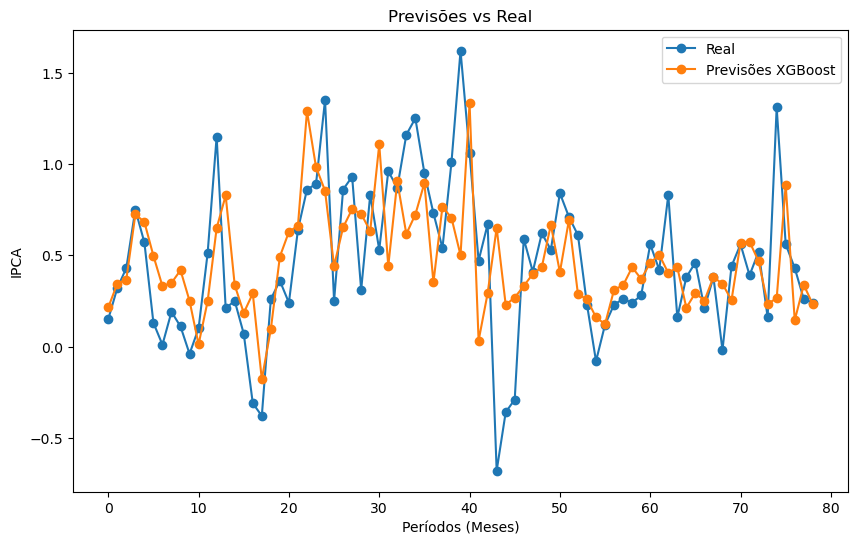

In [431]:
# Gráfico previsões vs real
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.plot(y, label='Real', marker='o')
plt.plot(y_chapeu, label='Previsões XGBoost', marker='o')
plt.title('Previsões vs Real')
plt.xlabel('Períodos (Meses)')
plt.ylabel('IPCA')
plt.legend()
plt.show()


## Conclusão

O modelo de previsão do IPCA utilizando **XGBoost** apresentou resultados razoáveis, mas com espaço para melhorias. Abaixo estão os principais pontos observados:

### Pontos Positivos:
1. **Métricas de Desempenho**:
  - O modelo obteve um **RMSE de 0.364**, indicando um erro médio relativamente baixo nas previsões.
  - O **MAE de 0.265** sugere que, em média, as previsões diferem dos valores reais em 0.265 pontos percentuais.
  - O **R² de 0.243** mostra que o modelo explica cerca de 24,3% da variabilidade do IPCA.

2. **Capacidade de Capturar Tendências**:
  - O modelo conseguiu acompanhar as tendências gerais do IPCA em períodos de estabilidade econômica.

3. **Otimização de Hiperparâmetros**:
  - A utilização do **Optuna** permitiu encontrar uma combinação eficiente de hiperparâmetros, melhorando o desempenho do modelo.

### Pontos a Melhorar:
1. **Baixo R²**:
  - O valor de 0.243 para o R² indica que o modelo não está capturando toda a variabilidade do IPCA. Isso sugere que variáveis importantes podem estar ausentes ou que as interações entre as variáveis não estão sendo bem representadas.

2. **Desempenho em Períodos de Alta Volatilidade**:
  - O modelo apresentou desvios significativos em períodos de maior volatilidade ou choques econômicos, indicando que ele pode não estar capturando adequadamente os efeitos de eventos externos.



```